## Imports

In [1]:
# imports
import torch
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import wandb
#from prettytable import PrettyTable
import random
import os
from datetime import datetime
from torch.optim import lr_scheduler
import pandas as pd


# local imports
from models_parameters import losses
from models_parameters import models
from utils import helper_functions
from utils.dataloader import Dataset as dataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

C:\Users\accou\anaconda3\envs\geo_env3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


# GENERAL SETTINGS

In [2]:
# Running where? "colab" or "ubs"
location = "local"

# chose which tile to train, test on eg "T30UXU"(9k) or "T30UUU"(3k)
sen2_tile_train = "all"#"T30UXU"
sen2_tile_val   = "all"#"T30UUU"
sen2_tile_test  = "all"

# chose dataloader transform - 'standardize', 'histogram_matching', 'moment_matching' or 'spot6
transform = "histogram_matching"

# chose where and how often to output - 'show' or output path 
# /share/projects/erasmus/sesure/working_dir/images/
#output_location = "C:\\Users\\accou\\Documents\\thesis\\images\\"
output_location="C:\\Users\\accou\\Documents\\thesis\\images\\images_RCAN_sat\\"


# selesct wether to load from checkpoint - 'None' for no checkpoint or checkpoint path
#load_checkpoint = "checkpoints\\RCAN_local_weightedLoss_histogram_matching_T30UXU__20-04-2022_22-20-57.pkl"
load_checkpoint = "None" #"models_parameters/model_files/rcan_4x.pt"

# Save checkpoints, 'None' to not save, otherwise path
save_checkpoint = True

# set WandB Project Name
model_name = "RCAN_local_pretrained"

In [3]:
# create run_name
run_name = model_name+"_"+transform+"_"+sen2_tile_train+"__"+str(datetime.now().strftime("%d-%m-%Y_%H-%M-%S"))
print(run_name)

RCAN_local_pretrained_histogram_matching_all__19-05-2022_14-53-10


# MODEL SETTINGS

In [4]:
# Set RCAN Args

args = {"n_resgroups":10,"n_resblocks":20,"n_feats":64,
        "reduction":16,"scale":4,"n_colors":3,             # reduction 16 default in code line 10 rcan.py (Channel Attention Layer)
        "res_scale":1,"data_train":"custom",               # res_scale default 1 set in line 30 rcan.py
        "rgb_mean" :(0, 0, 0),"rgb_range":1,               # mean&range&std currently deactivated in 117 of rcan.py
        }

In [5]:
# Load Model, wither straight definitions or loaded models
model = models.RCAN.create_model(args)

# load pretrained model weights
if load_checkpoint!="None":
  model.load_state_dict(torch.load(load_checkpoint))

# Load Loss Function
#loss_func = losses.loss_mae
from models_parameters.weighted_losses import weighted_loss
f = weighted_loss()
loss_func = f.get_loss
loss_func = losses.loss_mae

# enable benchmark for faster execution (only if inputs dont change)
torch.backends.cudnn.benchmark = True 

using custom dataset...


In [6]:
# TRANING SETTINGS
batch_size = 2
lr = 0.001
epochs = 100
plot_frequency = 100 # in batches

## Create Dataset Object

In [7]:
if location=="colab":
  working_directory = "/content/drive/MyDrive/thesis/"
  folder_path = "/content/drive/MyDrive/thesis/data/"
  dataset_file = "/content/drive/MyDrive/thesis/data/images_subfolders3.pkl"
if location=="ubs":
  working_directory = "/share/projects/erasmus/sesure/working_dir/"
  folder_path = "/share/projects/erasmus/sesure/working_dir/"
  dataset_file = "/share/projects/erasmus/sesure/working_dir/final_dataset.pkl"
if location=="local":
  working_directory = "C:\\Users\\accou\\Documents\\thesis"
  folder_path = "C:\\Users\\accou\\Documents\\thesis\\data_v2\\"
  dataset_file = "C:\\Users\\accou\\Documents\\thesis\\data_v2\\final_dataset.pkl"

# get dataset object
dataset_train = dataset(folder_path,dataset_file,transform=transform,test_train_val="train",sen2_amount=1, sen2_tile = sen2_tile_train, location=location)
dataset_val   = dataset(folder_path,dataset_file,transform=transform,test_train_val="val"  ,sen2_amount=1, sen2_tile = sen2_tile_val,   location=location)
#dataset_test  = dataset(folder_path,dataset_file,transform=transform,test_train_val="test",sen2_amount=1, sen2_tile = sen2_tile_val,   location=location)

# Inference only

In [8]:
"""
model = torch.load(load_checkpoint)

model = torch.load(load_checkpoint)

loader_val = DataLoader(dataset_train,batch_size=batch_size, shuffle=True, num_workers=0,pin_memory=True,drop_last=True)
model = model.eval()

for i in range(10):
    lr,hr = next(iter(loader_val))
    lr,hr,model = lr.to(device),hr.to(device),model.to(device)
    sr = model(lr).to(device)
    
    psnr_int = round(losses.loss_psnr(hr,helper_functions.interpolate_tensor(lr)).item(),2)
    psnr_pred = round(losses.loss_psnr(hr,sr).item(),2)
    helper_functions.plot_tensors_window(hr,lr,sr,psnr_int,psnr_pred,fig_path=output_location)
"""

'\nmodel = torch.load(load_checkpoint)\n\nmodel = torch.load(load_checkpoint)\n\nloader_val = DataLoader(dataset_train,batch_size=batch_size, shuffle=True, num_workers=0,pin_memory=True,drop_last=True)\nmodel = model.eval()\n\nfor i in range(10):\n    lr,hr = next(iter(loader_val))\n    lr,hr,model = lr.to(device),hr.to(device),model.to(device)\n    sr = model(lr).to(device)\n    \n    psnr_int = round(losses.loss_psnr(hr,helper_functions.interpolate_tensor(lr)).item(),2)\n    psnr_pred = round(losses.loss_psnr(hr,sr).item(),2)\n    helper_functions.plot_tensors_window(hr,lr,sr,psnr_int,psnr_pred,fig_path=output_location)\n'

## Train function

In [9]:
def test(generator,test_loader,amount=10):
    import utils.losses as losses
    # keep track of error metrics
    ssim_ls  = []
    psnr_ls  = []
    lpips_ls = []
    mae_ls = []
    ssim_int_ls  = []
    psnr_int_ls  = []
    lpips_int_ls = []
    mae_int_ls = []
    
    # perform 10 predictions, append results to list
    for i in range(0,amount):
        lr,hr = next(iter(test_loader))
        lr,hr = lr.to(device),hr.to(device)
        sr = generator(lr)
        l = losses.calculate_metrics(hr,lr,sr)
        
        
        lpips_ls.append(l[0])
        psnr_ls.append(l[1])
        ssim_ls.append(l[2])
        mae_ls.append(l[3])
        #lpips_int_ls.append(l[4])
        #psnr_int_ls.append(l[5])
        #ssim_int_ls.append(l[6])
        #mae_int_ls.append(l[6])
    
    def Average(lst):
        return sum(lst) / len(lst)
    
    ssim_avg  = round(Average(ssim_ls),5)
    psnr_avg  = round(Average(psnr_ls),5)
    lpips_avg = round(Average(lpips_ls),5)
    mae_avg = round(Average(mae_ls),5)
    #ssim_int_avg  = round(Average(ssim_int_ls),5)
    #psnr_int_avg  = round(Average(psnr_int_ls),5)
    #lpips_int_avg = round(Average(lpips_int_ls),5)
    #mae_int_avg = round(Average(mae_int_ls),5)
    
    wandb.log({'val_psnr': psnr_avg,
               'val_ssim': ssim_avg,
               'val_lpips': lpips_avg,
               'val_mae': mae_avg})

In [10]:
# implementation of model trainer function
def train_model(run_name,model,batch_size=1,lr=0.001,epochs=10,wandb_name="test",plot_frequency=10):
    
    logging=True          # log to WandB
    logging_val=True      # log validation loss in paralel to training loss
    plotting=True         # set if images should be plotted
    plot_frequency = plot_frequency    # set after how many batches images shoud be plotted

    if logging==True:
        wandb.init(name=run_name,project=wandb_name, entity="simon-donike")
        wandb.config = {
          "learning_rate": lr,
          "epochs": epochs,
          "batch_size": batch_size
        }
    
    # define loaders
    #loader_train = DataLoader(dataset_train,batch_size=batch_size, shuffle=True, num_workers=0,pin_memory=True,drop_last=True)
    #loader_val  = DataLoader(dataset_val,batch_size=1, shuffle=True, num_workers=0,pin_memory=True,drop_last=True)
    #from utils.dataloader_urban import Dataset
    #dataset_train = Dataset()
    loader_train = DataLoader(dataset_train,batch_size=batch_size, shuffle=True, num_workers=0,pin_memory=True,drop_last=True)
    loader_val = DataLoader(dataset_train,batch_size=batch_size, shuffle=True, num_workers=0,pin_memory=True,drop_last=True)
    
    
    print("dataloader instanciated!")
    print("Len. Train: ",len(loader_train),"(Batch Sz. "+str(batch_size),") Len. Val: ",len(dataset_val),"(Batch Sz. "+str(batch_size)+")")


    train_loss = []  # where we keep track of the training loss
    train_accuracy = []  # where we keep track of the training accuracy of the model
    val_loss = []  # where we keep track of the validation loss
    val_accuracy = []  # where we keep track of the validation accuracy of the model
    epochs = epochs  # number of epochs

    # initialize model
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr,momentum=0.9)
    #optimizer = optim.Adam(model.parameters())
    # set up LR Scheduler
    scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1,verbose=True)
    
    
    for e in range(epochs):
        model.train()
        #train_correct = 0
        batch_count=0
        for (x_train_batch, y_train_batch) in loader_train:
            batch_count = batch_count+1
            
            # send data to device
            x_train_batch = x_train_batch.to(device)
            y_train_batch = y_train_batch.to(device) # to float

            # forward pass
            y_hat = model(x_train_batch)  
            # compute the loss
            loss = loss_func(y_hat, y_train_batch)  

            loss.backward()  # obtain the gradients with respect to the loss
            optimizer.step()  # perform one step of gradient descent
            optimizer.zero_grad()  # reset the gradients to 0

            """ START LOGGING & PLOTTING """
            # Log train loss if not logging train+val loss
            if logging==True:
                wandb.log({'loss_train_step': loss.item() / len(x_train_batch),
                           'LR':scheduler.get_lr()[0]})
            # log val loss together with train and val loss
            if logging_val and logging:
              model.eval()
              x_val_batch, y_val_batch = next(iter(loader_val))
              x_val_batch = x_val_batch.to(torch.float).to(device)
              y_val_batch = y_val_batch.to(torch.float).to(device)
              y_hat_val = model(x_val_batch)
              loss_val = loss_func(y_hat_val, y_val_batch) 
              wandb.log({'loss_val_step': loss_val.item() / len(y_val_batch)})
              del x_val_batch
              del y_val_batch
              model.train()

            # log and plot after each batch/after plotting frequency
            if plotting==True:
                if batch_count%plot_frequency==0:
                    print('Epoch', e, ' Batch',batch_count,' finished.  No. of trained Images: '+str(batch_count*batch_size))
                    psnr_int = round(losses.loss_psnr(y_train_batch,helper_functions.interpolate_tensor(y_hat)).item(),2)
                    psnr_pred = round(losses.loss_psnr(y_train_batch,y_hat).item(),2)
                    helper_functions.plot_tensors_window(y_train_batch,x_train_batch,y_hat,fig_path=output_location)
                    print("Tensor Mean:",round(y_hat.mean().item(),6),"Max: ",round(y_hat.max().item(),6),"Min: ",round(y_hat.min().item(),6))
                    
                    # log metrics to WandB
                    test(model,loader_train)


        """ END OF EPOCH, logging and plotting """
        print ('Epoch', e+1, ' training finished.')
        scheduler.step()
        if save_checkpoint:
          torch.save(model.state_dict(), working_directory+"/checkpoints/"+run_name+".pkl")
        """
        PERFORM VALIDATION STEP after each epoch
        """
        model.eval()
        # perform inference 10 times on random images
        psnr_inter_list = []
        psnr_pred_list = []
        loss_val_list = []
        for i in range(5):
          # Load val Data and to device
          x_val_batch, y_val_batch = next(iter(loader_val))
          x_val_batch = x_val_batch.to(torch.float).to(device)
          y_val_batch = y_val_batch.to(torch.float).to(device)
        
          # perform inference step
          with torch.no_grad():
            pred = model(x_val_batch)

          # calculate metrics
          val_loss = loss_func(pred, y_val_batch).item()
          psnr_int = round(losses.loss_psnr(y_val_batch,helper_functions.interpolate_tensor(x_val_batch)).item(),2)
          psnr_pred = round(losses.loss_psnr(y_val_batch,pred).item(),2)
          psnr_inter_list.append(psnr_int)
          psnr_pred_list.append(psnr_pred)
          loss_val_list.append(val_loss)
        
        # TODO: implement SSIM
        print("VALIDATION: Visualizing 1 of 10 inference steps. Values are averages. Time: ",datetime.now().strftime("%d-%m-%Y %H:%M:%S"))
        psnr_int_avg = round(sum(psnr_inter_list) / len(psnr_inter_list),2)
        psnr_pred_avg = round(sum(psnr_pred_list) / len(psnr_pred_list),2)
        loss_val_avg = round(sum(loss_val_list) / len(loss_val_list),2)
        helper_functions.plot_tensors_window(y_train_batch,x_train_batch,y_hat,fig_path=output_location)
        # return model to train state
        model.train()

        # log validation accuracy after each epoch
        if logging==True:
            # log val loss
            wandb.log({'val_loss_epoch': loss_val_avg})
            # log val PSNR
            wandb.log({'val_PSNR_epoch': psnr_pred_avg})

    # Steps to perform after training is finished
    print("Training finished!")
    if logging==True:
        wandb.finish()

# Perform Training

wandb: Currently logged in as: simon-donike (use `wandb login --relogin` to force relogin)


dataloader instanciated!
Len. Train:  22167 (Batch Sz. 2 ) Len. Val:  4422 (Batch Sz. 2)
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 0  Batch 100  finished.  No. of trained Images: 200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.06077 Max:  0.186892 Min:  -0.071608
Epoch 0  Batch 200  finished.  No. of trained Images: 400


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.046771 Max:  0.202724 Min:  -0.065041
Epoch 0  Batch 300  finished.  No. of trained Images: 600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.045798 Max:  0.210992 Min:  -0.052774
torch.Size([3, 75, 58]) torch.Size([3, 300, 300])
Epoch 0  Batch 400  finished.  No. of trained Images: 800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.045565 Max:  0.214784 Min:  -0.045688
Epoch 0  Batch 500  finished.  No. of trained Images: 1000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.052039 Max:  0.36231 Min:  -0.102814
Epoch 0  Batch 600  finished.  No. of trained Images: 1200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.043592 Max:  0.282057 Min:  -0.040365
Epoch 0  Batch 700  finished.  No. of trained Images: 1400


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.052895 Max:  0.232247 Min:  -0.035887
Epoch 0  Batch 800  finished.  No. of trained Images: 1600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.062146 Max:  0.288802 Min:  -0.032806
Epoch 0  Batch 900  finished.  No. of trained Images: 1800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.052963 Max:  0.207326 Min:  -0.031338
Epoch 0  Batch 1000  finished.  No. of trained Images: 2000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.041212 Max:  0.188612 Min:  -0.030808
Epoch 0  Batch 1100  finished.  No. of trained Images: 2200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.045262 Max:  0.161994 Min:  -0.030132
Epoch 0  Batch 1200  finished.  No. of trained Images: 2400


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.0503 Max:  0.219171 Min:  -0.025841
Epoch 0  Batch 1300  finished.  No. of trained Images: 2600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.046623 Max:  0.146021 Min:  -0.024508
Epoch 0  Batch 1400  finished.  No. of trained Images: 2800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.079006 Max:  0.285541 Min:  -0.025159
Epoch 0  Batch 1500  finished.  No. of trained Images: 3000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.041343 Max:  0.175436 Min:  -0.020394
Epoch 0  Batch 1600  finished.  No. of trained Images: 3200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.056129 Max:  0.243433 Min:  -0.023959
Epoch 0  Batch 1700  finished.  No. of trained Images: 3400


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.054296 Max:  0.388562 Min:  -0.033985
Epoch 0  Batch 1800  finished.  No. of trained Images: 3600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.062123 Max:  0.327879 Min:  -0.022849
Epoch 0  Batch 1900  finished.  No. of trained Images: 3800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.04719 Max:  0.233982 Min:  -0.019975
Epoch 0  Batch 2000  finished.  No. of trained Images: 4000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.051705 Max:  0.251748 Min:  -0.018923
Epoch 0  Batch 2100  finished.  No. of trained Images: 4200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.028229 Max:  0.136316 Min:  -0.019875
Epoch 0  Batch 2200  finished.  No. of trained Images: 4400


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.072986 Max:  0.394091 Min:  -0.017655
Epoch 0  Batch 2300  finished.  No. of trained Images: 4600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.052428 Max:  0.202075 Min:  -0.017517
Epoch 0  Batch 2400  finished.  No. of trained Images: 4800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.042846 Max:  0.174522 Min:  -0.018844
Epoch 0  Batch 2500  finished.  No. of trained Images: 5000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.040136 Max:  0.232403 Min:  -0.018802
Epoch 0  Batch 2600  finished.  No. of trained Images: 5200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.058189 Max:  0.225623 Min:  -0.016074
Epoch 0  Batch 2700  finished.  No. of trained Images: 5400


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.051959 Max:  0.213196 Min:  -0.013073
Epoch 0  Batch 2800  finished.  No. of trained Images: 5600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.058561 Max:  0.230531 Min:  -0.013398
torch.Size([3, 75, 58]) torch.Size([3, 300, 300])
Epoch 0  Batch 2900  finished.  No. of trained Images: 5800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.066677 Max:  0.288095 Min:  -0.015894
Epoch 0  Batch 3000  finished.  No. of trained Images: 6000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.06273 Max:  0.255988 Min:  -0.01257
Epoch 0  Batch 3100  finished.  No. of trained Images: 6200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.06894 Max:  0.433844 Min:  -0.023261
Epoch 0  Batch 3200  finished.  No. of trained Images: 6400


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.052833 Max:  0.230526 Min:  -0.011136
Epoch 0  Batch 3300  finished.  No. of trained Images: 6600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.041543 Max:  0.303081 Min:  -0.017124
Epoch 0  Batch 3400  finished.  No. of trained Images: 6800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.051851 Max:  0.262451 Min:  -0.016871
Epoch 0  Batch 3500  finished.  No. of trained Images: 7000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.027265 Max:  0.2135 Min:  -0.013507
Epoch 0  Batch 3600  finished.  No. of trained Images: 7200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.053444 Max:  0.201499 Min:  -0.013511
Epoch 0  Batch 3700  finished.  No. of trained Images: 7400


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.050758 Max:  0.42025 Min:  -0.022846
Epoch 0  Batch 3800  finished.  No. of trained Images: 7600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.046577 Max:  0.343076 Min:  -0.015335
torch.Size([3, 75, 73]) torch.Size([3, 300, 300])
Epoch 0  Batch 3900  finished.  No. of trained Images: 7800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.048468 Max:  0.202283 Min:  -0.006867
Epoch 0  Batch 4000  finished.  No. of trained Images: 8000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.049329 Max:  0.319512 Min:  -0.03335
Epoch 0  Batch 4100  finished.  No. of trained Images: 8200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.026436 Max:  0.124597 Min:  -0.012865
Epoch 0  Batch 4200  finished.  No. of trained Images: 8400


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.056679 Max:  0.2383 Min:  -0.00765
Epoch 0  Batch 4300  finished.  No. of trained Images: 8600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.052678 Max:  0.267095 Min:  -0.009111
Epoch 0  Batch 4400  finished.  No. of trained Images: 8800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.054709 Max:  0.195887 Min:  -0.012854
torch.Size([3, 75, 58]) torch.Size([3, 300, 300])
Epoch 0  Batch 4500  finished.  No. of trained Images: 9000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.067171 Max:  0.359036 Min:  -0.016646
Epoch 0  Batch 4600  finished.  No. of trained Images: 9200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.041447 Max:  0.204242 Min:  -0.006524
Epoch 0  Batch 4700  finished.  No. of trained Images: 9400


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.047602 Max:  0.238367 Min:  -0.008688
Epoch 0  Batch 4800  finished.  No. of trained Images: 9600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.03677 Max:  0.179481 Min:  -0.010038
Epoch 0  Batch 4900  finished.  No. of trained Images: 9800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.047533 Max:  0.315314 Min:  -0.012493
Epoch 0  Batch 5000  finished.  No. of trained Images: 10000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.058129 Max:  0.239721 Min:  -0.011603
Epoch 0  Batch 5100  finished.  No. of trained Images: 10200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.070135 Max:  0.321374 Min:  -0.009667
Epoch 0  Batch 5200  finished.  No. of trained Images: 10400


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.029444 Max:  0.174131 Min:  -0.0143
Epoch 0  Batch 5300  finished.  No. of trained Images: 10600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.049235 Max:  0.187171 Min:  -0.008823
torch.Size([3, 75, 58]) torch.Size([3, 300, 300])
Epoch 0  Batch 5400  finished.  No. of trained Images: 10800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.051194 Max:  0.336336 Min:  -0.005955
Epoch 0  Batch 5500  finished.  No. of trained Images: 11000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.043787 Max:  0.280766 Min:  -0.007043
Epoch 0  Batch 5600  finished.  No. of trained Images: 11200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.055961 Max:  1.034408 Min:  -0.041341
Epoch 0  Batch 5700  finished.  No. of trained Images: 11400


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.093906 Max:  0.516976 Min:  -0.028882
Epoch 0  Batch 5800  finished.  No. of trained Images: 11600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.034615 Max:  0.277078 Min:  -0.026383
Epoch 0  Batch 5900  finished.  No. of trained Images: 11800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.076506 Max:  1.641101 Min:  -0.1982
Epoch 0  Batch 6000  finished.  No. of trained Images: 12000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.04461 Max:  0.372518 Min:  -0.007903
Epoch 0  Batch 6100  finished.  No. of trained Images: 12200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.055779 Max:  0.185748 Min:  -0.002028
Epoch 0  Batch 6200  finished.  No. of trained Images: 12400


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.053166 Max:  0.23538 Min:  -0.003435
Epoch 0  Batch 6300  finished.  No. of trained Images: 12600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.078282 Max:  0.489163 Min:  -0.03588
Epoch 0  Batch 6400  finished.  No. of trained Images: 12800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.042528 Max:  0.275915 Min:  -0.014195
Epoch 0  Batch 6500  finished.  No. of trained Images: 13000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.05721 Max:  0.218203 Min:  -0.005416
Epoch 0  Batch 6600  finished.  No. of trained Images: 13200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.064329 Max:  0.303949 Min:  -0.016416
Epoch 0  Batch 6700  finished.  No. of trained Images: 13400


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.071422 Max:  0.429664 Min:  -0.002939
Epoch 0  Batch 6800  finished.  No. of trained Images: 13600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.059437 Max:  0.207132 Min:  -0.003812
Epoch 0  Batch 6900  finished.  No. of trained Images: 13800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.078887 Max:  0.282791 Min:  -0.022572
Epoch 0  Batch 7000  finished.  No. of trained Images: 14000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tensor Mean: 0.072307 Max:  0.221228 Min:  -0.004075


KeyboardInterrupt: 

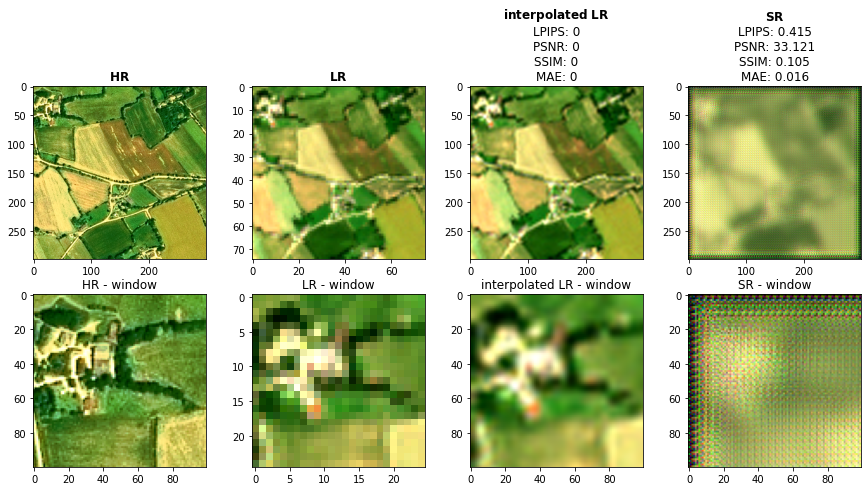

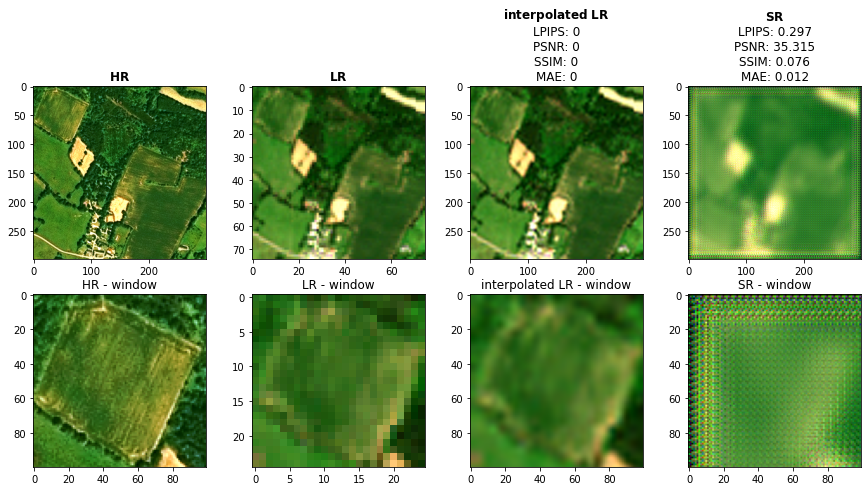

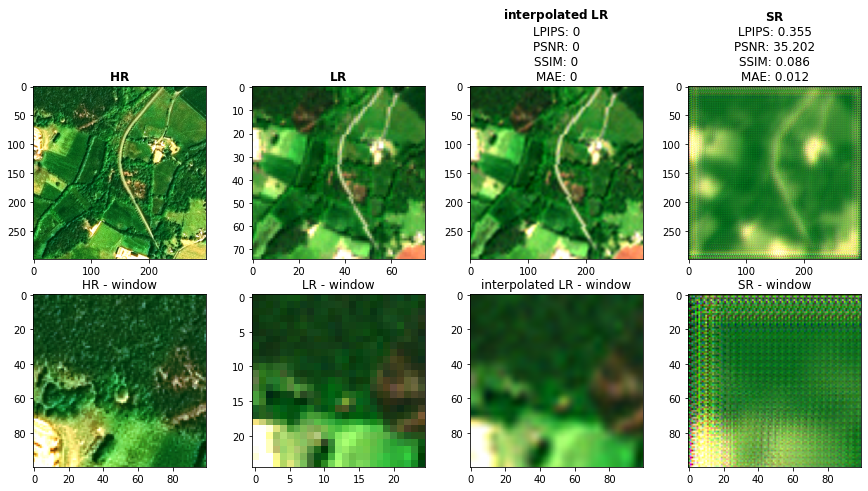

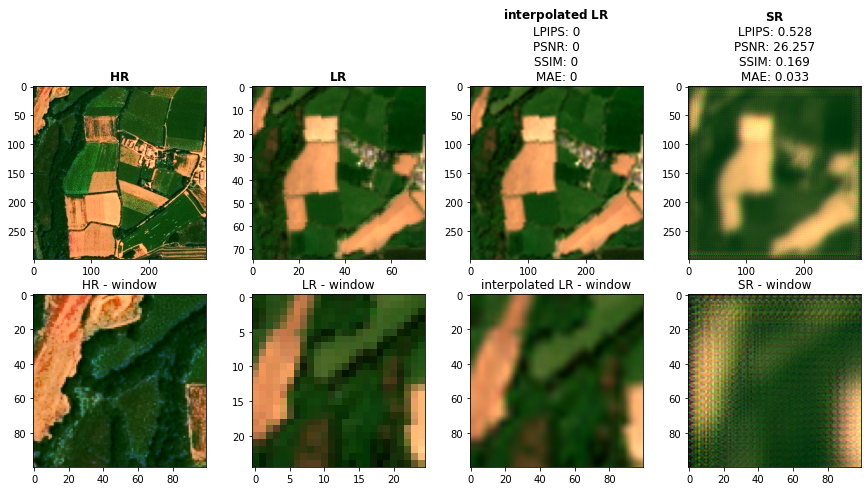

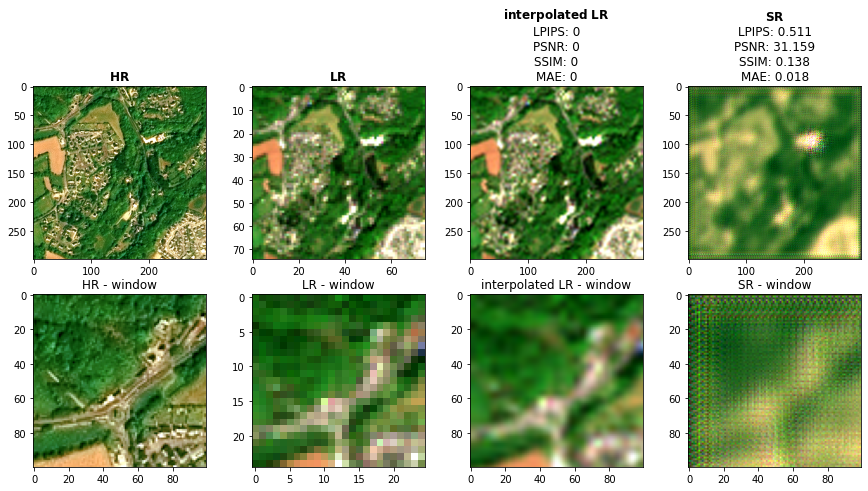

In [ ]:
train_model(run_name,model=model,batch_size=batch_size,lr=lr,epochs=epochs,wandb_name=model_name,plot_frequency=plot_frequency)

In [ ]:
wandb.finish()